In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import scipy.linalg as LIN
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.weight'] = 'medium'

%matplotlib inline

In [3]:
np.random.seed(199)

In [41]:
# get left and right eigenvectors associated with the 
# largest eigenvalue. 
def getLREigVec(mat):
    eigVals_, eigL_, eigR_ = LIN.eig(mat, left=True)
    idx_max = np.argmax(eigVals_)
    t = eigL_[:, idx_max]
    h = eigR_[:, idx_max]
    return t, h

# compute gradient (Eq.(5) in the write-up)
def gradient(adjMat, S, Alpha, J):
    n = adjMat.shape[0]
    alpha1, alpha2, alpha3 = Alpha
    I = np.identity(n)
    
    ## for 1st term, to increase the largest eigenvalue
    ## of the subgraph
    S_adjMat = adjMat[np.ix_(S, S)]
    t_S, h_S = getLREigVec(S_adjMat)
    c_1 = np.dot(t_S, h_S)
    P_1 = np.outer(t_S, h_S)
    g_1 = np.zeros(adjMat.shape)
    g_1[np.ix_(S, S)] = (P_1 + np.transpose(P_1) - np.multiply(P_1, np.identity(len(S)))) / c_1
    g_1 = np.multiply(g_1, J)

    ## for 2nd term, to not increase the largest eigenvalue
    ## too much
    t, h = getLREigVec(adjMat)
    c_2 = np.dot(t, h)
    P_2 = np.outer(t, h)
    g_2 = ( P_2 + np.transpose(P_2) - np.multiply(P_2, I) ) / c_2
    g_2 = np.multiply(g_2, J)

    ## for 3rd term, to increase the centrality of the subgraph
    x_S = np.zeros(len(G.nodes))
    x_S[S] = 1
    X_S = np.outer(x_S, x_S)
    P_3 = np.transpose( 2 * X_S - (np.multiply(X_S, I)) )
    g_3 = np.dot(np.multiply(P_3, I), np.ones((n, n))) - P_3
    g_3 = g_3 + np.transpose(g_3) - np.multiply(g_3, I)
    # no need to change the edges' weights within the subgraph
    g_3[np.ix_(S, S)] = 0
    g_3 = np.multiply(g_3, J)
    
    g = np.real( alpha1 * g_1 - alpha2 * g_2 + (alpha3/len(S)) * g_3 )
    return g

# get the largest eigenvalue
def maxEig(mat):
    eigVals = LIN.eigvals(mat)
    return np.max(eigVals)

# get a submatrix of mat indexed by S
def getSubmat(mat, S):
    return mat[np.ix_(S, S)]

# get the Laplacian matrix corresponding to mat
def getL(mat):
    degsVec = np.dot(mat, np.ones(mat.shape[1]))
    return np.diag(degsVec) - mat

# compute centrality
def getCent(L, x_S):
    return np.real( np.dot(x_S, np.dot(L, x_S)) / len(S) )

In [42]:
n = 30
G = nx.barabasi_albert_graph(n, 2)

In [55]:
adjMat = np.asarray(nx.adjacency_matrix(G).todense())
J = np.copy(adjMat)
    
# trade-off parameters
alpha1, alpha2, alpha3 = 0.5, 0.3, 0.2
ret = {'Lambda': [], 'Lambda_S': [], 'Centrality': [], 'Utility': []}
Gradient = []

# subgraph is the induced subgraph of S
S = [1, 2, 3]
# x_S is the characteristic vector of S
x_S = np.zeros(len(G.nodes))
x_S[S] = 1

Iter = 100
lr = 0.1
adjMat_0 = np.copy(adjMat)

# gradient ascent 
for ii in range(Iter):
    # compute eigenvalues
    lambda_1 = np.real(maxEig(adjMat))
    lambda_1_S = np.real(maxEig(getSubmat(adjMat, S)))
    
    # compute centrality
    L = getL(adjMat)
    Cent = getCent(L, x_S)
    
    # compute utility
    utility = np.real( alpha1 * lambda_1_S - alpha2 * lambda_1 + alpha3 * Cent )
    
    # printing and recording intermediate results
    if ii % 10 == 0:
        print("Lambda_S: %.4f      Lambda: %.4f      Centrality: %i      Utility: %.4f" % (lambda_1_S, lambda_1, Cent, utility))
    ret['Lambda'].append(lambda_1)
    ret['Lambda_S'].append(lambda_1_S)
    ret['Centrality'].append(Cent)
    ret['Utility'].append(utility)
    
    # update gradient
    g = gradient(adjMat, S, [alpha1, alpha2, alpha3], J)
    Gradient.append(np.copy(g))
    adjMat = adjMat + lr * g

# convert results into DataFrame
ret = pd.DataFrame(ret)

Lambda_S: 1.4142      Lambda: 5.1137      Centrality: 4      Utility: 0.1063
Lambda_S: 1.8547      Lambda: 5.0968      Centrality: 4      Utility: 0.3660
Lambda_S: 2.2700      Lambda: 5.1509      Centrality: 4      Utility: 0.5854
Lambda_S: 2.6590      Lambda: 5.2628      Centrality: 5      Utility: 0.7690
Lambda_S: 3.0239      Lambda: 5.4153      Centrality: 5      Utility: 0.9250
Lambda_S: 3.3687      Lambda: 5.5947      Centrality: 5      Utility: 1.0609
Lambda_S: 3.6972      Lambda: 5.7921      Centrality: 5      Utility: 1.1824
Lambda_S: 4.0123      Lambda: 6.0022      Centrality: 5      Utility: 1.2933
Lambda_S: 4.3165      Lambda: 6.2215      Centrality: 5      Utility: 1.3964
Lambda_S: 4.6118      Lambda: 6.4476      Centrality: 5      Utility: 1.4934


Text(0.5, 1.0, 'alpha_1=0.50  alpha_2=0.30  alpha_3=0.20')

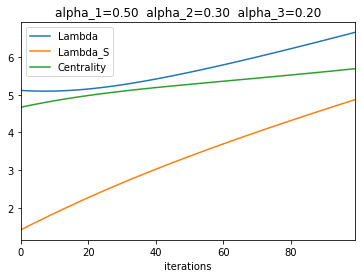

In [56]:
# plot results
ret[['Lambda', 'Lambda_S', 'Centrality']].plot(kind='line')
plt.xlabel('iterations')
plt.title('alpha_1=%.2f  alpha_2=%.2f  alpha_3=%.2f' % (alpha1, alpha2, alpha3))
# plt.savefig('../ret/5-3-2.pdf')

#  This Line below is irrelevant

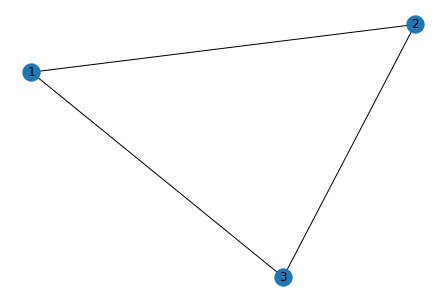

In [57]:
G = nx.Graph()
G.add_nodes_from([1, 2, 3])
G.add_edges_from([(1,2), (1, 3), (2, 3)])
nx.draw(G, with_labels=True)

In [58]:
A = np.asarray( nx.adjacency_matrix(G).todense() )
L = np.asarray( nx.laplacian_matrix(G).todense() )

In [85]:
xs = np.zeros(3)
xs[[0, 1]] = 1

In [86]:
np.dot(xs, np.dot(L, xs))

2.0

In [92]:
XS = np.outer(xs, xs)
P = np.transpose( 2 * XS - (np.multiply(XS, np.identity(3))) )

a = np.dot(np.multiply(P, np.identity(3)), np.ones((3, 3)))
g = a - P
g = g + np.transpose(g) - np.multiply(g, np.identity(3))
g = np.multiply(g, A)
g

array([[ 0., -2.,  1.],
       [-2.,  0.,  1.],
       [ 1.,  1.,  0.]])

In [93]:
# Delta = np.zeros((3,3))
# Delta[0, 1] = 1
# L_tilde = getL(A + Delta)
Delta = 0.1 * g
L_tilde = getL(A + Delta)
np.dot(xs, np.dot(L_tilde, xs)) - np.dot(xs, np.dot(L, xs)) 

0.20000000000000018

In [79]:
np.trace(np.dot(Delta, XS))

6.0

In [61]:
eigVals_, eigL_, eigR_ = LIN.eig(L, left=True)

In [63]:
np.dot(eigR_, np.transpose(eigR_))

array([[ 1.0958487 , -0.25049315,  0.15464445],
       [-0.25049315,  1.15464445,  0.0958487 ],
       [ 0.15464445,  0.0958487 ,  0.74950685]])

In [65]:
T = np.zeros((3,3))
for i in range(3):
    T = T + np.outer(eigR_[:, i], eigR_[:, i])
T

array([[ 1.0958487 , -0.25049315,  0.15464445],
       [-0.25049315,  1.15464445,  0.0958487 ],
       [ 0.15464445,  0.0958487 ,  0.74950685]])

In [80]:
A

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]], dtype=int64)